In [1]:
# Importing libraries and packages
import os
import cv2 
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

from sklearn.model_selection import train_test_split



Using TensorFlow backend.


In [2]:
images = []
label = []

img_path = r'C:\Users\melte\Desktop\ML\Jobs'
listImgs = os.listdir(img_path)


# LOAD IN THE IMAGES
for k in range(0,len(listImgs)):
    img = cv2.imread(('\\'.join([img_path,listImgs[k]])).format(img_path),-1)
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if "Arzt" in listImgs[k]:
        label.append(1)
        images.append(RGB)

    elif "Kfz" in listImgs[k]:
        label.append(0)
        images.append(RGB)

    pass 

n = len(images)

#Create test and train set
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#transform labels to numpy arrays for crosstab: 
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

#number of instances in train, test, val 
n_train = len(X_train)
n_test = len(X_test)
n_val = len(X_val)

## OpenFace embedding

In [3]:
import face_recognition

#creating 1x128d feature embeddings from dlibs face_recognition library for train, test and val 
dlib_embedding_train = []
dlib_embedding_test = []

for n in range(len(X_train)):
    dlib_embedding_train.append(face_recognition.api.face_encodings(X_train[n], known_face_locations=None, num_jitters=10)) 
dlib_embedding_train = np.array(dlib_embedding_train)

for n in range(len(X_test)):
    dlib_embedding_test.append(face_recognition.api.face_encodings(X_test[n], known_face_locations=None, num_jitters=10))
dlib_embedding_test = np.array(dlib_embedding_test)

# #Flatten the embeddings to vectors: 
dlib_embedding_train = np.reshape(dlib_embedding_train, (n_train, 1*128))
dlib_embedding_test = np.reshape(dlib_embedding_test, (n_test, 1*128))


In [4]:
images = []
label = []

img_path = r'C:\Users\melte\Desktop\ML\Jobs'
listImgs = os.listdir(img_path)


# LOAD IN THE IMAGES
for k in range(0,len(listImgs)):
    img = cv2.imread(('\\'.join([img_path,listImgs[k]])).format(img_path),-1)
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if "Anwalt" in listImgs[k]:
        label.append(1)
        images.append(gray)

    elif "Kfz" in listImgs[k]:
        label.append(0)
        images.append(gray)

    pass 

n = len(images)

#Create test and train set
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#transform labels to numpy arrays for crosstab: 
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

#number of instances in train, test, val 
n_train = len(X_train)
n_test = len(X_test)
n_val = len(X_val)

## PCA Embedding

In [5]:
#flatten arrays for further processing 
img_size = 224
X_train = X_train.reshape(n_train, img_size*img_size)
X_test = X_test.reshape(n_test, img_size*img_size)
X_val = X_val.reshape(n_val, img_size*img_size)

from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler

#defining components based on % of all components 
c1 = int(n_train*0.8)
c2 = int(n_train*0.5)
c3 = int(n_train*0.2)

#Scaling the input
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

mu = np.mean(X_train_s, axis=0)

#No. of principal components 
n_components = c2

#___________________________________________________________________________
# LINEAR PCA
pca = PCA(n_components=n_components)
pca.fit(X_train_s)

X_train_r = np.dot(pca.transform(X_train_s), pca.components_)
X_train_r += mu

X_test_r = np.dot(pca.transform(X_test_s), pca.components_)
X_test_r += mu


C:\Users\melte\Anaconda3\envs\me\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\melte\Anaconda3\envs\me\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\melte\Anaconda3\envs\me\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\melte\Anaconda3\envs\me\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
#now we're loading in the images with the Keras ImageDataGenerator module
from keras.preprocessing.image import ImageDataGenerator

# Anwalt_Call, Arzt_Anwalt, Kfz_Arzt, Arzt_Call, Kfz_Anwalt, Kfz_Call
# BauBE_KunstBE, BauCeo_BauBE, BauCeo_KunstBE, BauCeo_KunstCeo, KunstCeo_BauBE, KunstCeo_KunstBE
# FinBE_KomCeo, IndBE_KunstCeo 

#Setting paths and parameters: 
train_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Kfz_Anwalt\Train'
test_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Kfz_Anwalt\Test'
val_dir = r'C:\Users\melte\Desktop\ML\Binary\Block1\Kfz_Anwalt\Val'

nTrain = 76
nTest = 24
nVal = 20

# nTrain = 768
# nTest = 240 
# nVal = 192 

c = 2   #classes
batch_size = 20

#######################
### DATA GENERATOR ####
#######################

datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#############################################
### LOADING IN TRAIN, TEST AND VALIDATION SETS ####
#############################################

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 76 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## VGG16 Embedding

In [7]:
#Let's initiate our feature and label arrays: 
VGG_train_features = np.zeros(shape=(nTrain, 7 , 7, 512))
VGG_train_labels = np.zeros(shape=(nTrain,c))

VGG_test_features = np.zeros(shape=(nTest, 7 , 7, 512))
VGG_test_labels = np.zeros(shape=(nTest,c))


In [8]:
#This is the pretrained network we're using for transfer learning: 
model_vgg16 = VGGFace(model='vgg16',include_top=False, input_shape=(224, 224, 3))



i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    VGG_train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    VGG_train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break       
VGG_train_features = np.reshape(VGG_train_features, (nTrain, 7 * 7 * 512))

i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    VGG_test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    VGG_test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTest:
        break       
VGG_test_features = np.reshape(VGG_test_features, (nTest, 7 * 7 * 512))


## ResNet50 Embedding

In [9]:
#Let's initiate our feature and label arrays: 
res_train_features = np.zeros(shape=(nTrain, 1 , 1 , 2048))
res_train_labels = np.zeros(shape=(nTrain,c))

res_test_features = np.zeros(shape=(nTest, 1 , 1 , 2048))
res_test_labels = np.zeros(shape=(nTest,c))


In [10]:
#This is the pretrained network we're using for transfer learning: 
model_vgg16 = VGGFace(model='resnet50',include_top=False, input_shape=(224, 224, 3))



i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    res_train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    res_train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break       
res_train_features = np.reshape(res_train_features, (nTrain, 1 * 1 * 2048))

i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    res_test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    res_test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTest:
        break       
res_test_features = np.reshape(res_test_features, (nTest, 1 * 1 * 2048))


## InceptionV3 Embedding

In [11]:
from keras.applications import InceptionV3
import keras.layers as layers 
from keras import models

#This is the pretrained network we're using for transfer learning: 
model_vgg16 = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

#Let's initiate our feature and label arrays: 
train_features = np.zeros(shape=(nTrain, 5, 5, 2048))
train_labels = np.zeros(shape=(nTrain,c))

test_features = np.zeros(shape=(nTest, 5, 5, 2048))
test_labels = np.zeros(shape=(nTest,c))


i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
         
train_features = np.reshape(train_features, (nTrain, 5* 5*  2048))

i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = model_vgg16.predict(inputs_batch)
    test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTest:
        break       
test_features = np.reshape(test_features, (nTest, 5* 5*  2048))


## SVM and kNN

In [12]:
# dlib_embedding_train  y_train
# X_train_r    y_train
# VGG_train_features    VGG_test_labels
# res_test_features     res_test_labels
# train_features     train_labels

In [13]:
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve

#dlib
SVM_dlib = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM_dlib.fit(dlib_embedding_train, y_train)
dlib_predict = SVM_dlib.predict(dlib_embedding_test).ravel()


#pca
SVM_pca = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM_pca.fit(X_train_r, y_train)
pca_predict = SVM_pca.predict(X_test_r).ravel()


#VGG
SVM_vgg = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM_vgg.fit(VGG_train_features, VGG_train_labels[:,0])
vgg_predict = SVM_vgg.predict(VGG_test_features).ravel()


#Resnet
SVM_res = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM_res.fit(res_train_features, res_train_labels[:,0])
res_predict = SVM_res.predict(res_test_features).ravel()


#Inception
SVM_in = SVC(kernel = 'rbf', gamma='scale', C=20)
SVM_in.fit(train_features, train_labels[:,0])
in_predict = SVM_in.predict(test_features).ravel()

In [14]:
# dlib_embedding_train  y_train
# X_train_r    y_train
# VGG_train_features    VGG_test_labels
# res_test_features     res_test_labels
# train_features     train_labels

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report


knn_dlib = KNeighborsClassifier(n_neighbors = 15, p = 2, metric = 'minkowski')
knn_dlib.fit(dlib_embedding_train, y_train)
dlib_knn = knn_dlib.predict(dlib_embedding_test).ravel()


knn_pca = KNeighborsClassifier(n_neighbors = 15, p = 2, metric = 'minkowski')
knn_pca.fit(X_train_r, y_train)
pca_knn = knn_pca.predict(X_test_r).ravel()


knn_vgg = KNeighborsClassifier(n_neighbors = 15, p = 2, metric = 'minkowski')
knn_vgg.fit(VGG_train_features, VGG_train_labels[:,0])
vgg_knn = knn_vgg.predict(VGG_test_features).ravel()


knn_res = KNeighborsClassifier(n_neighbors = 15, p = 2, metric = 'minkowski')
knn_res.fit(res_train_features, res_train_labels[:,0])
res_knn = knn_res.predict(res_test_features).ravel()


knn_in = KNeighborsClassifier(n_neighbors = 15, p = 2, metric = 'minkowski')
knn_in.fit(train_features, train_labels[:,0])
in_knn = knn_in.predict(test_features).ravel()


In [16]:
# dlib_embedding_train  y_train
# X_train_r    y_train
# VGG_train_features    VGG_test_labels
# res_test_features     res_test_labels
# train_features     train_labels

## ROC

In [17]:
from sklearn.metrics import roc_curve

fpr_dlib_SVM, tpr_dlib_SVM, thresholds_dlib_SVM = roc_curve(y_test, dlib_predict)
fpr_dlib_knn, tpr_dlib_knn, thresholds_dlib_knn = roc_curve(y_test, dlib_knn)
fpr_pca_SVM, tpr_pca_SVM, thresholds_pca_SVM = roc_curve(y_test, pca_predict)
fpr_pca_knn, tpr_pca_knn, thresholds_pca_knn = roc_curve(y_test, pca_knn)
fpr_vgg_SVM, tpr_vgg_SVM, thresholds_vgg_SVM = roc_curve(VGG_test_labels[:,0], vgg_predict)
fpr_vgg_knn, tpr_vgg_knn, thresholds_vgg_knn = roc_curve(VGG_test_labels[:,0], vgg_knn)
fpr_res_SVM, tpr_res_SVM, thresholds_res_SVM = roc_curve(res_test_labels[:,0], res_predict)
fpr_res_knn, tpr_res_knn, thresholds_res_knn = roc_curve(res_test_labels[:,0], res_knn)
fpr_in_SVM, tpr_in_SVM, thresholds_in_SVM = roc_curve(test_labels[:,0], in_predict)
fpr_in_knn, tpr_in_knn, thresholds_in_knn = roc_curve(test_labels[:,0], in_knn)

In [18]:
from sklearn.metrics import auc
auc_dlib_SVM = auc(fpr_dlib_SVM, tpr_dlib_SVM)
auc_dlib_knn = auc(fpr_dlib_knn, tpr_dlib_knn)
auc_pca_SVM = auc(fpr_pca_SVM, tpr_pca_SVM)
auc_pca_knn = auc(fpr_pca_knn, tpr_pca_knn)
auc_vgg_SVM = auc(fpr_vgg_SVM, tpr_vgg_SVM)
auc_vgg_knn = auc(fpr_vgg_knn, tpr_vgg_knn)
auc_res_SVM = auc(fpr_res_SVM, tpr_res_SVM)
auc_res_knn = auc(fpr_res_knn, tpr_res_knn)
auc_in_SVM = auc(fpr_in_SVM, tpr_in_SVM)
auc_in_knn = auc(fpr_in_knn, tpr_in_knn)

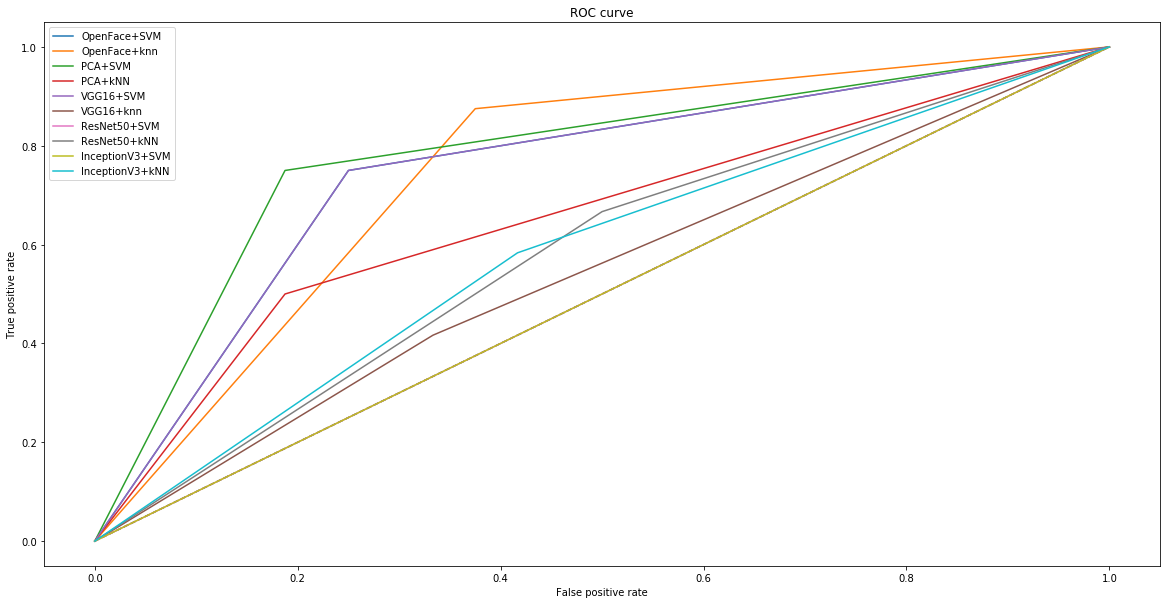

In [19]:
plt.figure(figsize=(20,10))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_dlib_SVM, tpr_dlib_SVM, label='OpenFace+SVM'.format(auc_dlib_SVM))
plt.plot(fpr_dlib_knn, tpr_dlib_knn, label='OpenFace+knn'.format(auc_dlib_knn))

plt.plot(fpr_pca_SVM, tpr_pca_SVM, label='PCA+SVM'.format(auc_pca_SVM))
plt.plot(fpr_pca_knn, tpr_pca_knn, label='PCA+kNN'.format(auc_pca_knn))

plt.plot(fpr_vgg_SVM, tpr_vgg_SVM, label='VGG16+SVM'.format(auc_vgg_SVM))
plt.plot(fpr_vgg_knn, tpr_vgg_knn, label='VGG16+knn'.format(auc_vgg_knn))

plt.plot(fpr_res_SVM, tpr_res_SVM, label='ResNet50+SVM'.format(auc_res_SVM))
plt.plot(fpr_res_knn, tpr_res_knn, label='ResNet50+kNN'.format(auc_res_knn))

plt.plot(fpr_in_SVM, tpr_in_SVM, label='InceptionV3+SVM'.format(auc_in_SVM))
plt.plot(fpr_in_knn, tpr_in_knn, label='InceptionV3+kNN'.format(auc_in_knn))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()